# ABOUT THIS NOTEBOOK
## Purpose
This notebook attempts to fit a neural network with 3 hidden layers.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Attempt three hidden layers (fully connected)
* Use validation curves to tune hyper parameters:
    * Learning Rate
    * Number of Steps
    * Dropout
    * Batch Size

# LOAD LIBRARY PACKAGES

In [2]:
# Import the required library packages
import os
import re
import timeit
import itertools

import tensorflow as tf
import tensorflow.contrib.learn as skflow

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six'

Read in packages from os, tensorflow, numpy, pandas, matplotlib, seaborn, sklearn & six


# LOAD PICKLE FILE

In [3]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [4]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# ADD GAP FOR PREVIOUS TIME SLOTS

In [5]:
# Create new gap features for previous 3 time slots
pdata_set['gap_t-1'] = (pdata_set['demand_t-1'] - pdata_set['supply_t-1'])
pdata_set['gap_t-2'] = (pdata_set['demand_t-2'] - pdata_set['supply_t-2'])
pdata_set['gap_t-3'] = (pdata_set['demand_t-3'] - pdata_set['supply_t-3'])

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [6]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 58) (66528, 58) 




## Generate scaled features for train & test sets

In [7]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3',
                  'gap_t-1', 'gap_t-2', 'gap_t-3',
                  'time_slot', 'week_day'
                 ]   

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

## Generate validation set

In [8]:
nn_predictors = [0,1,3,4,6,7,8,9,10,25,26,28,29]

train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(gX_train[:, nn_predictors], gy_train, test_size=0.33)
test_dataset = gX_test[:, nn_predictors]
test_labels  = gy_test

In [9]:
print train_dataset.shape, valid_dataset.shape, train_labels.shape, valid_labels.shape

(89147, 13) (43909, 13) (89147,) (43909,)


# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [10]:
def test_scores(Xtrain, ytrain, Xtest, ytest, learning_rate, hidden_units, dropout, steps, batch_size):
    """
    Generate train and test scores for selected neural network.

    Parameters
    ----------
    Xtrain : array-like, shape (n_samples, n_features)
              Training vector, where n_samples is the number of samples and
              n_features is the number of features.

    ytrain : array-like, true/expected values for training set
    
    Xtest : array-like, shape (n_samples, n_features)
             Test vector, where n_samples is the number of samples and
             n_features is the number of features.

    ytest : array-like, true/expected values for test set
  
    learning_rate : self explanatory
    
    hidden_units : self explanatory
    
    dropout : self explanatory
    
    steps : self explanatory
    
    batch_size : self explanatory

    """

    # Setup optimizer, regressor
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    regressor = skflow.DNNRegressor(hidden_units=hidden_units,
                                    optimizer=optimizer,
                                    dropout=float(dropout)
                                   )

    # Fit
    regressor.fit(Xtrain, 
                  ytrain,
                  steps=steps,
                  batch_size=batch_size
                 )

    # Predict and score
    train_prediction = target_scaler.inverse_transform(regressor.predict(Xtrain))
    test_prediction  = target_scaler.inverse_transform(regressor.predict(Xtest))

    print_score(X_train['gap'], train_prediction, 
                X_test['gap'], test_prediction
               )
    

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

## Generate Validation Curves

In [11]:
def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))


def plot_validation_curve(X, y, 
                          param_name, param_range,
                          learning_list, hidden_list, dropout_list, steps_list, batch_list, 
                          plot_title, x_label, y_label):
    """
    Generate a simple plot of the validation curve for one hyperparameter.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : name of the hyper parameter that is being tested
    
    param_range : range of the hyper parameter
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes
    
    plot_title : string
            Title for the chart.
            
    x_label: label for x-axis of the plot
    
    y_label: lable for y-axis of the plot
    
    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
    """
    
    # Cross validation with 3 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=3, test_size=0.2, random_state=0)
    
    start = timeit.default_timer()
    
    train_scores, test_scores = validation_curvenn(X, 
                                                   y,
                                                   cv,
                                                   learning_list,
                                                   hidden_list, 
                                                   dropout_list, 
                                                   steps_list, 
                                                   batch_list
                                                  )
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
        
    # Print Scores
    for param, train_score, test_score in zip(param_range, train_scores_mean, test_scores_mean):
        print ('{0}: {1:9.2f}\tTrain Score: {2:.3f}\tCV Score: {3:.3f}' .format(param_name, float(param), float(train_score), float(test_score)))
    
    plt.figure(figsize=(15,8))
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    plt.show()
    
def validation_curvenn(X, y, cv, learning_list, hidden_list, dropout_list, steps_list, batch_list):
    """
    Generate train and validation scores for provided hyperparameter range.

    Parameters
    ----------
    estimator : tensor flow object that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, true/expected values

    cv : cross validation function to use
    
    learning_list : list of learning_rates
    
    hidden_list : list of hidden_units
    
    dropout_list : list of dropout rates
    
    steps_list : list of steps
    
    batch_list : list of batch sizes

    """
    train_scores = []
    cv_scores = []

    # Iterate over list of hyper parameters
    for learning_rate, hidden_units, dropout, steps, batch_size in itertools.product(learning_list, hidden_list, 
                                                                                     dropout_list, steps_list, batch_list):
    
        print ('Learning Rate: {0:}\tHidden Units: {1:}\tDropout: {2:}\tSteps: {3:6d}\tBatch Size: {4:5d}'
               .format(learning_rate, hidden_units, float(dropout), steps, batch_size))
        
        # Set up optimizer, regressor
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        regressor = skflow.DNNRegressor(hidden_units=hidden_units,
                                        optimizer=optimizer, 
                                        dropout=float(dropout)
                                       )
    
        train_scores_set = []
        cv_scores_set = []
        
        # Fit and generate scores
        for train_index, cv_index in cv:
            regressor.fit(X[train_index],
                          y[train_index],
                          steps=steps, 
                          batch_size=batch_size)
    
            # Predict and score
            train_prediction = regressor.predict(X[train_index])
            train_score = metrics.mean_squared_error(train_prediction, y[train_index])
            train_scores_set.append(train_score)
        
            cv_prediction = regressor.predict(X[cv_index])
            cv_score = metrics.mean_squared_error(cv_prediction, y[cv_index])
            cv_scores_set.append(cv_score)
        
        train_scores.append(train_scores_set)
        cv_scores.append(cv_scores_set)
    
    return(train_scores,cv_scores)

# Three Hidden Layers w/ Same Size as Input

## Baseline

In [11]:
# Generate baseline scores
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=0.03, 
            hidden_units=[13,13,13], 
            dropout=0.1, 
            steps=10000, 
            batch_size=3000
            )

		MEAN^2		R2		MAPE
TRAIN     	185.801		0.903		0.324
TEST      	330.352		0.857		0.342


## Validation Curves

### Learning Rate

Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Learning Rate: 0.01	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Learning Rate: 0.006	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Learning Rate: 0.003	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Learning Rate: 0.001	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Learning Rate: 0.0001	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Learning Rate: 1e-05	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Validation Curves Runtime: 0h:24m:21s


Learning Rate:      0.03	Train Score: 0.114	CV Score: 0.116
Learning Rate:      0.01	Train Score: 0.117	CV Score: 0.118
Learning Rate:      0.01	Train Score: 0.122	CV Score: 0.125
Learning Rate:      0.00	Train Score: 0.130	CV Score: 0.134
Learning Rate:      0.00	Train Score: 0.154	CV Score: 0.157
Learning R

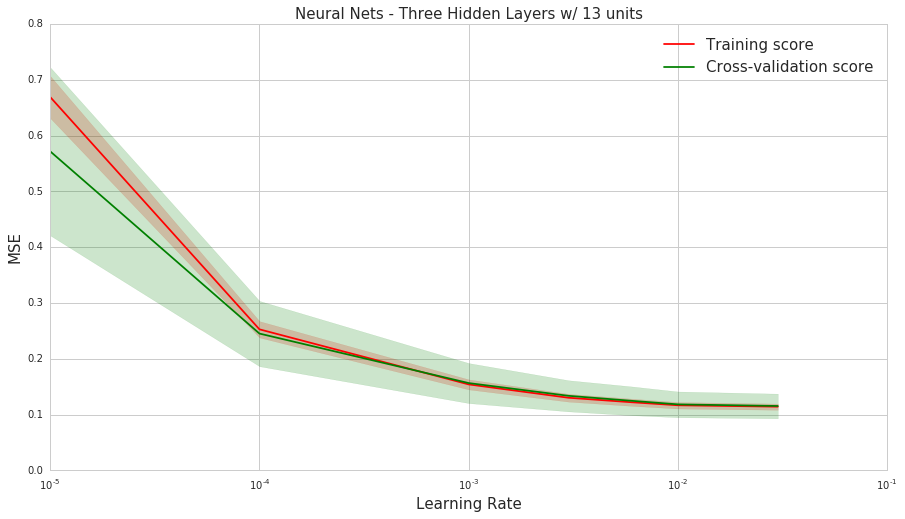

In [13]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Learning Rate', 
                      param_range=[3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5],
                      learning_list=[3e-2,1e-2,6e-3,3e-3,1e-3,1e-4,1e-5], 
                      hidden_list=[[13, 13, 13]], 
                      dropout_list=[0.1], 
                      steps_list=[10000], 
                      batch_list=[3000],
                      plot_title='Neural Nets - Three Hidden Layers w/ 13 units', 
                      x_label='Learning Rate', 
                      y_label='MSE'
                     )

We will select learning rate of 0.03 that results in low training & CV scores. Lower learning rates eventually lead to an increase in error.

### Number of Steps

Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:    100	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:   1000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  10000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  30000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  50000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps:  75000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps: 100000	Batch Size:  3000
Validation Curves Runtime: 1h:24m:36s


Number of Steps:    100.00	Train Score: 0.211	CV Score: 0.216
Number of Steps:   1000.00	Train Score: 0.133	CV Score: 0.135
Number of Steps:  10000.00	Train Score: 0.135	CV Score: 0.129
Number of Steps:  30000.00	Train Score: 0.128	CV Score: 0.125
Number of Steps:  50000.00	Train Score: 0.124	CV Score: 0.120
Number

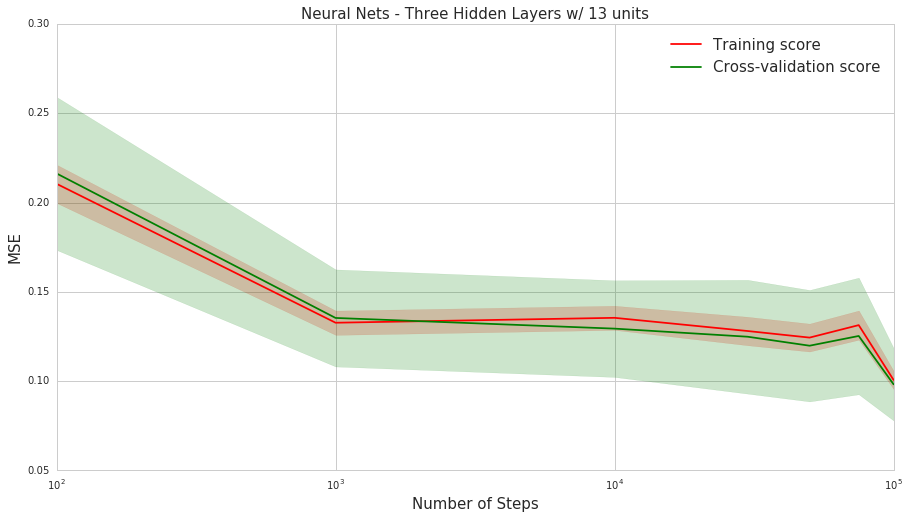

In [15]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Number of Steps', 
                      param_range=[100,1000,10000,30000,50000,75000,100000],
                      learning_list=[0.03], 
                      hidden_list=[[13, 13, 13]], 
                      dropout_list=[0.1], 
                      steps_list=[100,1000,10000,30000,50000,75000,100000], 
                      batch_list=[3000],
                      plot_title='Neural Nets - Three Hidden Layers w/ 13 units', 
                      x_label='Number of Steps', 
                      y_label='MSE'
                     )

We will select 100000 number of steps that results in low training & CV scores. It is possible that more steps might reduce the error further... however the runtime for large number of steps is much higher.

### Dropout

Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps: 100000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.2	Steps: 100000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.3	Steps: 100000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.4	Steps: 100000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.5	Steps: 100000	Batch Size:  3000
Validation Curves Runtime: 1h:50m:53s


Dropout:      0.10	Train Score: 0.102	CV Score: 0.100
Dropout:      0.20	Train Score: 0.159	CV Score: 0.148
Dropout:      0.30	Train Score: 0.273	CV Score: 0.232
Dropout:      0.40	Train Score: 0.485	CV Score: 0.409
Dropout:      0.50	Train Score: 0.622	CV Score: 0.430


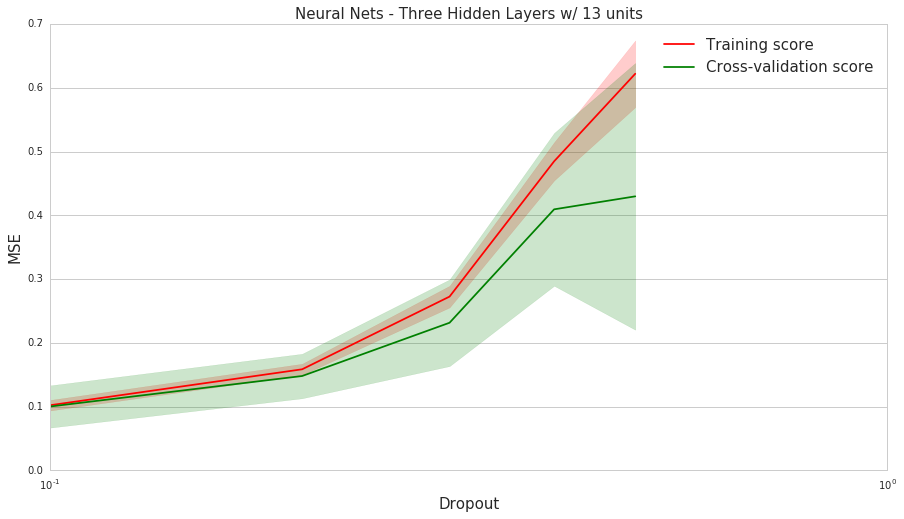

In [16]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Dropout', 
                      param_range=[0.1,0.2,0.3,0.4,0.5],
                      learning_list=[0.03], 
                      hidden_list=[[13, 13, 13]], 
                      dropout_list=[0.1,0.2,0.3,0.4,0.5], 
                      steps_list=[100000], 
                      batch_list=[3000],
                      plot_title='Neural Nets - Three Hidden Layers w/ 13 units', 
                      x_label='Dropout', 
                      y_label='MSE')

Lower or no dropout results in higher scores. However, using dropout ensures that the network is more robust to noise. We will select dropout of 0.1.

### Batch Size

Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps: 100000	Batch Size:  3000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps: 100000	Batch Size:  6000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps: 100000	Batch Size: 10000
Learning Rate: 0.03	Hidden Units: [13, 13, 13]	Dropout: 0.1	Steps: 100000	Batch Size: 30000
Validation Curves Runtime: 3h:16m:56s


Batch Size:   3000.00	Train Score: 0.084	CV Score: 0.081
Batch Size:   6000.00	Train Score: 0.089	CV Score: 0.082
Batch Size:  10000.00	Train Score: 0.099	CV Score: 0.089
Batch Size:  30000.00	Train Score: 0.094	CV Score: 0.084


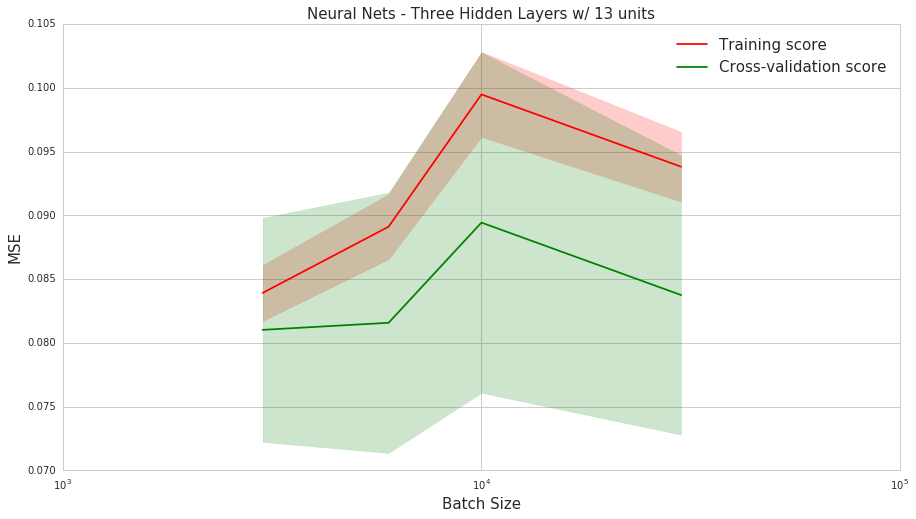

In [15]:
plot_validation_curve(X=train_dataset, 
                      y=train_labels, 
                      param_name='Batch Size', 
                      param_range=[3000,6000,10000,30000],
                      learning_list=[0.03], 
                      hidden_list=[[13, 13, 13]], 
                      dropout_list=[0.1], 
                      steps_list=[100000], 
                      batch_list=[3000,6000,10000,30000],
                      plot_title='Neural Nets - Three Hidden Layers w/ 13 units', 
                      x_label='Batch Size', 
                      y_label='MSE')

We will select 10000 for batch size since it produces good training & cv scores.

## Test Scores

In [12]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=0.03, 
            hidden_units=[13, 13, 13], 
            dropout=0.1, 
            steps=100000, 
            batch_size=3000
            )

		MEAN^2		R2		MAPE
TRAIN     	203.259		0.894		0.288
TEST      	396.596		0.829		0.303


In [ ]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=0.03, 
            hidden_units=[13, 13, 13], 
            dropout=0.1, 
            steps=100000, 
            batch_size=10000
            )

In [13]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=0.03, 
            hidden_units=[13, 26, 13], 
            dropout=0.1, 
            steps=100000, 
            batch_size=3000
            )

		MEAN^2		R2		MAPE
TRAIN     	171.235		0.910		0.297
TEST      	378.334		0.836		0.310


In [ ]:
# Use the hyper parameters selected from the validation curves
test_scores(Xtrain=gX_train, 
            ytrain=gy_train,
            Xtest=gX_test, 
            ytest=gy_test,
            learning_rate=0.03, 
            hidden_units=[13, 26, 13], 
            dropout=0.1, 
            steps=100000, 
            batch_size=10000
            )